# Activation Maximization on MNIST

Sources:
- https://raghakot.github.io/keras-vis/
- https://github.com/raghakot/keras-vis

Lets build the mnist model and train it for 5 epochs. It should get to about ~99% test accuracy.

In [1]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [ ]:
batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('mnist_to_experiment.h5')

In [ ]:
model.summary()

In [2]:
model = keras.models.load_model('mnist_to_experiment.h5')

## Dense Layer Visualizations

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

Lets start by visualizing input that maximizes the output of node 0. Hopefully this looks like a 0.

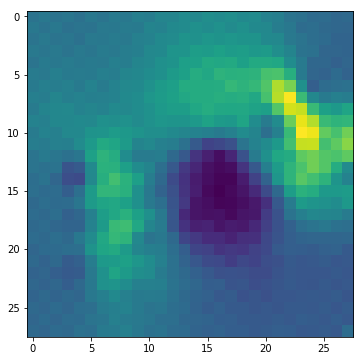

In [3]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

### Debugging step 0: Note the standard deviation of the optimizer 

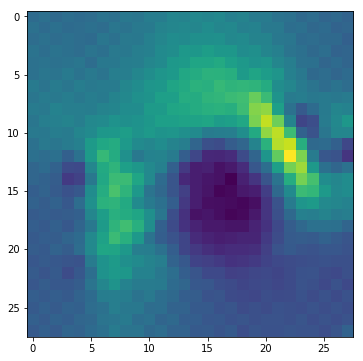

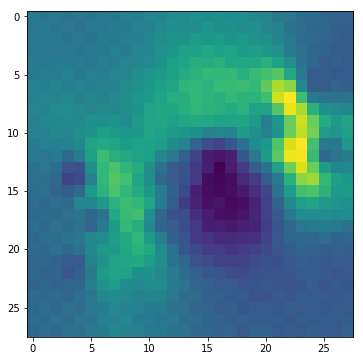

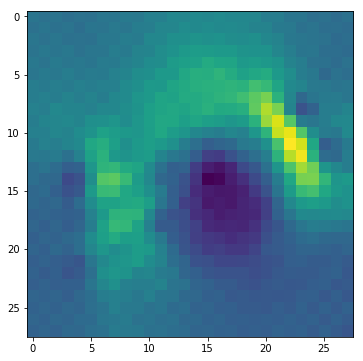

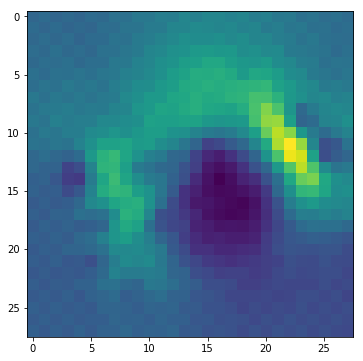

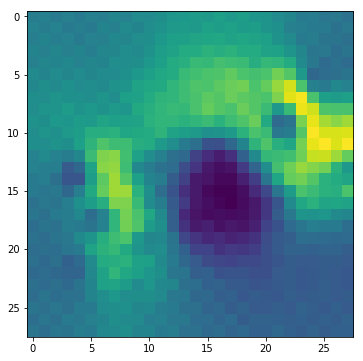

In [4]:
for _ in range(5):
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
    plt.figure()
    plt.imshow(img[..., 0])

Hmm, it sort of looks like a 0, but not as clear as we hoped for. Activation maximization is notorious because regularization parameters needs to be tuned depending on the problem. Lets enumerate all the possible reasons why this didn't work very well.
    
- The input to network is preprocessed to range (0, 1). We should specify `input_range = (0., 1.)` to constrain the input to this range.
- The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use `verbose=True` and examine individual loss values.

Lets do these step by step and see if we can improve it.

### Debugging step 1: Specifying input_range

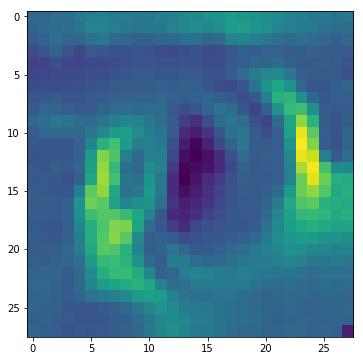

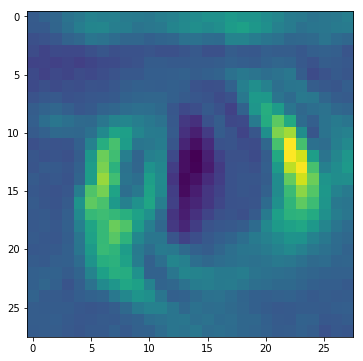

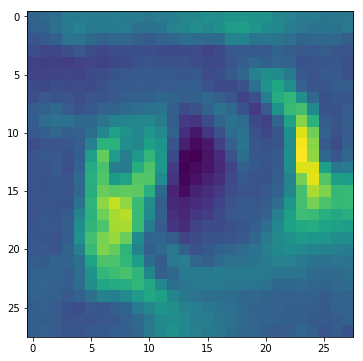

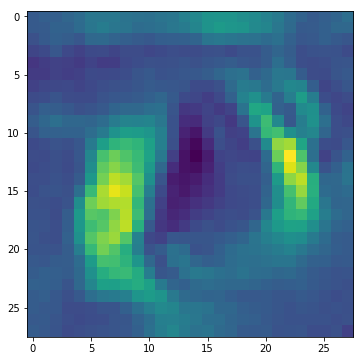

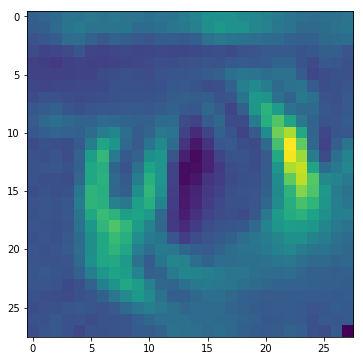

In [5]:
for _ in range(5):
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
    plt.figure()
    plt.imshow(img[..., 0])

Much better but still seems noisy. Lets examining the losses with `verbose=True` and tuning the weights.

### Debugging step 2: Tuning regularization weights

For L-p norm regularization see 3.2.1, For Total Variation regularization see 3.2.2 in https://arxiv.org/pdf/1512.02017v3.pdf

One of the issues with activation maximization is that the input can go out of the training distribution space. Total variation and L-p norm are used to provide some hardcoded image priors for natural images. For example, Total variation ensures that images are blobber and not scattered. Unfotunately, sometimes these losses can dominate the main `ActivationMaximization` loss.

Lets see what individual losses are, with `verbose=True`

In [ ]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

In this case, `ActivationMax Loss` is not bouncing bouncing around and converging? Perhaps we could get that loss to be lower by reducing weights of other losses that might be dominating the overall loss being minimized. 

The simplest way to tune these weights is to first start with `0.` weights for all regularization losses.

In [ ]:
for _ in range(5):
    img = visualize_activation(model, layer_idx, filter_indices=5, input_range=(0., 1.), 
                           tv_weight=0., lp_norm_weight=0., verbose=False)
    plt.figure()
    plt.imshow(img[..., 0])

It does indeed go to much lower values, but the image looks less natural. Let's try varous range of total variation weights to enforce naturalness.

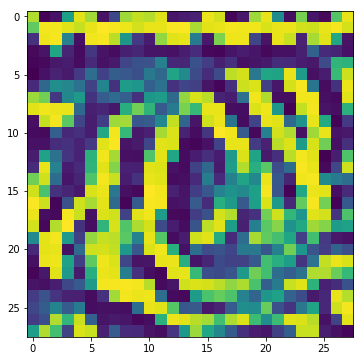

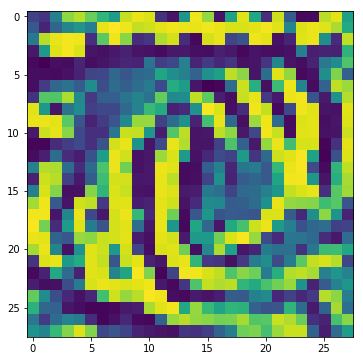

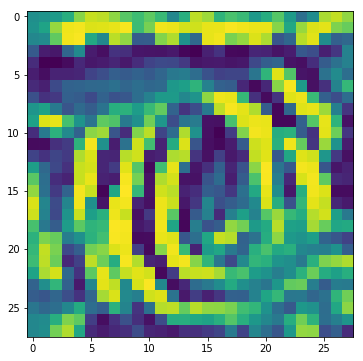

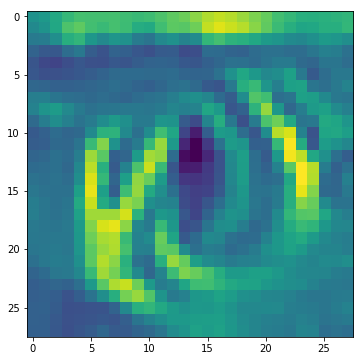

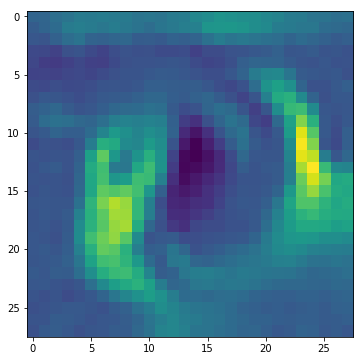

In [6]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.imshow(img[..., 0])

We can see how total variation loss is enforcing blobbiness. In this case the default value of `tv_weight=10` seems to work very well. The point of this exercise was to show how weights can be tuned.

Lets visualize all other output categories and see what we get.

In [ ]:
for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

Pretty cool. Its amazing that we can even generate an input image via backprop! 

Obviously you can tune the visualizations to look better by experimenting with `image_modifiers`, lp-norm weight etc. Basically, a regularizer is needed to enforce image naturalness prior to limit the input image search space. By this point, GANs should come to your mind. We could easily take a GAN trained on mnist and use discriminator loss as a regularizer. For using custom loss, you can use `visualize_activation_with_losses` API.

Feel free to submit a PR if you try the GAN regularizer :)

### Playing with L-p norm

In [ ]:
for lp_norm_weight in [1, 100, 1000, 10000]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=10, lp_norm_weight=lp_norm_weight)
    plt.figure()
    plt.imshow(img[..., 0])
    print(np.mean(img), np.std(img))

## Mixing outputs

The API to `visualize_activation` accepts `filter_indices`. This is generally meant for *multi label* classifiers, but nothing prevents us from having some fun. 

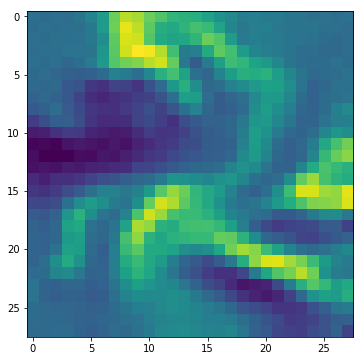

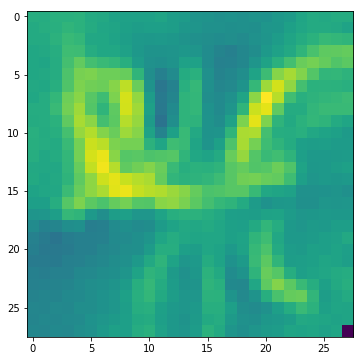

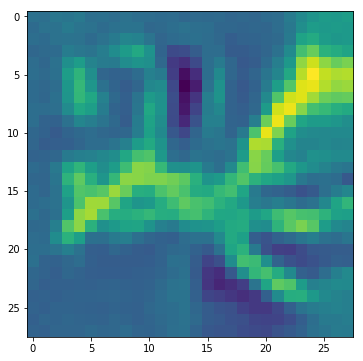

In [7]:
img = visualize_activation(model, layer_idx, filter_indices=[2], input_range=(0., 1.))
plt.figure()
plt.imshow(img[..., 0])

img = visualize_activation(model, layer_idx, filter_indices=[4], input_range=(0., 1.))
plt.figure()
plt.imshow(img[..., 0])

img = visualize_activation(model, layer_idx, filter_indices=[2, 4], input_range=(0., 1.))
plt.figure()
plt.imshow(img[..., 0])

Compare this to the `1` generated above and you should be able to see the difference. Nifty indded!

## Visualizations without swapping softmax

As alluded at the beginning of the tutorial, we want to compare and see what happens if we didnt swap out softmax for linear activation.

In [ ]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

It does not work! The reason is that maximizing an output node can be done by minimizing other outputs. Softmax is weird that way. It is the only activation that depends on other node output(s) in the layer.